In [1]:
import sys
from pathlib import Path
sys.path.append(Path("../modules/").absolute().__str__())

from data_utils import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import re
from typing import Dict

In [2]:
def load_dataset_and_preprocess(dataset_path: str):
    df = load_dataset(dataset_path)
    df_timeout = df.loc[df['execution'] == 'timeout']
    df_empty = df.drop(df_timeout.index).loc[df['execution'].str.startswith("[]")]
    df_fail = df.drop(df_timeout.index).drop(df_empty.index).loc[df['execution'].str.startswith('exception')]
    df_no_errors = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)
    
    return {
        "base": df,
        "timeout": df_timeout,
        "empty": df_empty,
        "fail": df_fail,
        "no_errors": df_no_errors
    }

In [3]:
path_to_original_executed_dataset = "../outputs/final_queries_v1.1_full_execution_limit_10.parquet.gzip"
original_dataset = load_dataset_and_preprocess(path_to_original_executed_dataset)

In [4]:
path_to_final_executed_dataset = "../outputs/dataset_pipeline/final_fq17/final_fq17-generated_prompt-executed.parquet.gzip"
final_dataset = load_dataset_and_preprocess(path_to_final_executed_dataset)

path_to_final_executed_dataset_no_limit = "../outputs/dataset_pipeline/final_fq17_with_no_limit/final_fq17-generated_prompt-executed.parquet.gzip"
final_dataset_no_limit = load_dataset_and_preprocess(path_to_final_executed_dataset_no_limit)

Number of timed out requests: 234
Number of failed requests: 113
Number of empty responses: 106
Number of successful responses: 2392
Number of timed out requests: 172
Number of failed requests: 47
Number of empty responses: 115
Number of successful responses: 2504
Number of timed out requests: 186
Number of failed requests: 66
Number of empty responses: 113
Number of successful responses: 2473


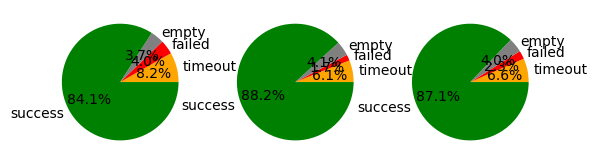

In [5]:
def analyze_responses(datasets, ax):
    print(f"Number of timed out requests: {len(datasets['timeout'])}")
    print(f"Number of failed requests: {len(datasets['fail'])}")
    print(f"Number of empty responses: {len(datasets['empty'])}")
    print(f"Number of successful responses: {len(datasets['no_errors'])}")

    labels = ["timeout", "failed", "empty", "success"]
    sizes  = [
        len(datasets['timeout']),
        len(datasets['fail']),
        len(datasets['empty']),
        len(datasets['no_errors'])
    ]

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])
    
# Call the function with your dataframes as arguments
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
analyze_responses(original_dataset, ax1)
analyze_responses(final_dataset, ax2)
analyze_responses(final_dataset_no_limit, ax3)

In [6]:
def find_error_type(x: str):
    if not isinstance(x, str):
        return None
    
    http_error = re.compile(r"exception: ([0-9]+)")
    module_request_error = re.compile(r"exception: module 'requests.exceptions'")
    invalid_json_error = re.compile(r"Connection broken: InvalidChunkLength")
    server_timeout_error = re.compile(r"java.util.concurrent.TimeoutException")
    empty_error = re.compile(r"exception: query is empty")
    
    http_error_match = http_error.search(x[:20])
    
    if http_error_match != None:
        return http_error_match.group(1)
    
    if module_request_error.search(x[:50]):
        return "requests"
    
    if invalid_json_error.search(x[:100]):
        return "invalid JSON"
    
    if server_timeout_error.search(x[len(x)-10000:]):
        return "server timeout"
    
    if empty_error.search(x[:100]):
        return "empty query"
    
    return None

def analyse_errors(datasets: Dict):
    datasets['fail']['error_type'] = datasets['fail'].apply(lambda x: find_error_type(x['execution']), axis=1)

    distinct_errors = datasets['fail'].error_type.unique()

    print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
    for err in distinct_errors:
        if err == None:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'].isnull()])}")
        else:
            print(f"Number of {str(err)}: {len(datasets['fail'].loc[datasets['fail']['error_type'] == err])}")

    print()

    for err in distinct_errors:
        if err == None:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'].isnull()].iloc[0]['execution'][:256]}")
        else:
            print(f"Example of {str(err)}: {datasets['fail'].loc[datasets['fail']['error_type'] == err].iloc[0]['execution'][:256]}")

In [7]:
analyse_errors(original_dataset)
analyse_errors(final_dataset)
analyse_errors(final_dataset_no_limit)

There is 2 types of errors: 500, 400
Number of 500: 42
Number of 400: 71

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of 400: exception: 400 Client Error: Bad Request for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+schema%3A+%3Chttp%3A%2F%2Fschema.org%2F%3E%0APREFIX+xsd%3A+%3Chttp%3A%2F%2Fwww.w3.org%2F2001%2FXMLSchema%23%3E%0APREFIX+wdt%3A+%3Chttp%3A
There is 3 types of errors: 500, 400, None
Number of 500: 42
Number of 400: 4
Number of None: 1

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=PREFIX+bd%3A+%3Chttp%3A%2F%2Fwww.bigdata.com%2Frdf%23%3E%0APREFIX+p%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2F%3E%0APREFIX+pq%3A+%3
Example of

error_type
400    71
500    42
Name: count, dtype: int64
error_type
500    42
400     4
Name: count, dtype: int64
error_type
500         42
requests    17
400          4
Name: count, dtype: int64


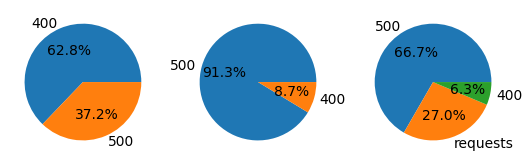

In [8]:
def plot_error_types(datasets: Dict, ax):
    value_counts = datasets['fail']['error_type'].value_counts()
    print(value_counts)

    labels = list(datasets['fail']['error_type'].value_counts().index)
    sizes = list(value_counts)
    
    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plot_error_types(original_dataset, ax1)
plot_error_types(final_dataset, ax2)
plot_error_types(final_dataset_no_limit, ax3)

In [9]:
def generate_index_of_errors(all_errors: pd.Series):
    error_types = sorted(list(all_errors.value_counts().index))
    return {x[0]: i for i, x in enumerate(error_types)}

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    pattern_multiple_same_prefixes = re.compile(r"Multiple prefix declarations for prefix")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
    if pattern_multiple_same_prefixes.search(last_error):
        errors.append("Prefix duplicates")
        
    return errors

def classify_500_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_stackoverflow = re.compile(r"StackOverflowError")
    pattern_geo_input_no_resolve_point = re.compile(r"Input could not be resolved as point")
    pattern_estimated_time_too_long = re.compile(r"The estimated execution time")
    pattern_out_of_memory = re.compile(r"MemoryManagerOutOfMemory")
    pattern_nullpointerexception = re.compile(r"java.lang.NullPointerException")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_stackoverflow.search(last_error):
        errors.append("stack overflow")
    if pattern_geo_input_no_resolve_point.search(last_error):
        errors.append("GeoSpatialSearchException: input could not be resolved as point")
    if pattern_estimated_time_too_long.search(last_error):
        errors.append("estimated time to execute too long")
    if pattern_out_of_memory.search(last_error):
        errors.append("Out of memory")
    if pattern_nullpointerexception.search(last_error):
        errors.append("NullPointerException")
        
    return errors

def classify_requests_errors(execution_result):
    pattern = re.compile(r"exception: module 'requests.exceptions' has no attribute 'JSONDecodeError'")
    errors = []
    
    if pattern.search(execution_result[:100]):
        errors.append("no attribute 'JSONDecodeError'")
    
    return errors


def classify_all_errors(execution_result: str):
    if not isinstance(execution_result, str) or execution_result == None:
        return None
    
    error = find_error_type(execution_result)
    
    
    if error == None:
        return None
    elif error == "400":
        return classify_400_errors(execution_result)
    elif error == "500":
        return classify_500_errors(execution_result)
    elif error == "requests":
        return classify_requests_errors(execution_result)
    elif error == "invalid JSON":
        return ["invalid JSON"]
    elif error == "server timeout":
        return ["server timeout"]
    elif error == "empty query":
        return ['empty query']
    
    
    raise NotImplementedError(f"This function is not implemented for errors other than 400, 500, requests, invalid JSON, server timeout, found: {error}")

ERROR_INDEX = {
    "undefined prefix": 0,
    "parse exception due to limit": 1,
    "parse exception": 2,
    "lexical error": 3,
    "non-aggregate variable in select expression": 4,
    "Prefix duplicates": 5,
    "stack overflow": 6,
    "GeoSpatialSearchException: input could not be resolved as point": 7,
    "estimated time to execute too long": 8,
    "Out of memory": 9,
    "no attribute 'JSONDecodeError'": 10,
    "invalid JSON": 11,
    "server timeout": 12,
    "NullPointerException": 13,
    "empty query": 14
}

original_dataset['fail']['error_classified'] = original_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
original_dataset['fail']['ierror_classified'] = original_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset['fail']['error_classified'] = final_dataset['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset['fail']['ierror_classified'] = final_dataset['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

final_dataset_no_limit['fail']['error_classified'] = final_dataset_no_limit['fail'].apply(lambda x: classify_all_errors(x['execution']), axis=1)
final_dataset_no_limit['fail']['ierror_classified'] = final_dataset_no_limit['fail'].apply(lambda x: ERROR_INDEX[x['error_classified'][0]] if isinstance(x['error_classified'], list) else None, axis=1)

error_classified
[lexical error]                                  36
[parse exception]                                16
[undefined prefix]                               16
[parse exception due to limit]                    2
[non-aggregate variable in select expression]     1
Name: count, dtype: int64
error_classified
[parse exception]                 3
[parse exception due to limit]    1
Name: count, dtype: int64
error_classified
[parse exception]    4
Name: count, dtype: int64


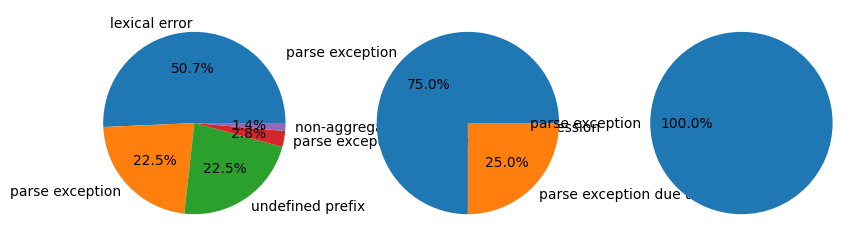

In [10]:
def plot_error_400(datasets, ax):
    df_error400 = datasets['fail'].loc[datasets['fail']['error_type'] == '400']

    value_counts = df_error400.error_classified.value_counts()
    print(value_counts)

    labels = list(map(lambda x: ", ".join(x), list(df_error400.error_classified.value_counts().index)))
    sizes = list(value_counts)

    ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 20))
plot_error_400(original_dataset, ax1)
plot_error_400(final_dataset, ax2)
plot_error_400(final_dataset_no_limit, ax3)

In [11]:
# df_error400 = final_dataset['fail'].loc[final_dataset['fail']['error_type'] == '400']
# df_error400.head()